In [1]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
from IPython import display
import PIL
import glob
import imageio

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = "gandy_warhol/raw_data"
BATCH_SIZE = 32
IMAGE_SIZE = [128, 128]

In [3]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/images_resized/*.jpeg'))

In [4]:
filenames = [file for file in filenames if file.endswith('jpeg')]

In [5]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [6]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [-1,1] range.
  img = normalize(img)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices(filenames)

2022-03-07 16:47:10.567439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 16:47:10.578351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 16:47:10.579044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 16:47:10.580189: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).cache().batch(256)

In [9]:
image_batch = next(iter(train_ds))

2022-03-07 16:47:11.335243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-07 16:47:11.410924: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [10]:
def show_batch(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        img = image_batch[n, :, :] * 0.5 + 0.5
        plt.imshow(img)
        plt.axis("off")

In [11]:
EPOCHS = 25000
noise_dim = 100
num_examples_to_generate = 25

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [12]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten,BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(Reshape((4, 4, 256)))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    for i in range(3):
        model.add(UpSampling2D())
        model.add(Conv2D(256, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
    model.add(Conv2D(3, kernel_size=3, padding='same'))
    model.add(Activation('tanh'))

    return model

In [14]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0

In [15]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

2022-03-07 16:47:12.534219: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


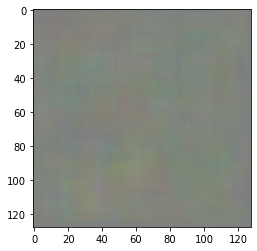

In [16]:
img = generated_image[0]  * 0.5 + 0.5
plt.imshow(img)

In [17]:
def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2,input_shape=[128, 128, 3], padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00205108]], shape=(1, 1), dtype=float32)


In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def save_model(epoch):
    output_path = 'leading_blind_models'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    filename = os.path.join(output_path, f"model_gen_epoch_{epoch}.h5")
    generator.save(filename)

In [25]:
def save_singles(epoch, total = 25):
    for i in range(25):
        output_path = f"leading_blind_singles/img_{i}"
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        filename = os.path.join(output_path, f"img_{i}_epoch_{epoch}.png")
        prediction = generator.predict(seed[i])[0]
        prediction = prediction*0.5 + 0.5
        fig = plt.figure(figsize=(4,4))
        plt.axis('off')
        plt.imshow(prediction)
        plt.savefig(filename)

In [26]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        img = predictions[i, :, :] * 0.5 + 0.5
        plt.imshow(img)
        plt.axis('off')

    plt.savefig(f'leading_blind_groups/epoch_{epoch}.png')
    plt.show()

In [31]:
seed = tf.random.normal([25, 1, 100])


In [32]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch, seed)
            save_singles(epoch, seed)
        if epoch % 100 == 0:
            save_model(epoch)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)
    save_singles(epochs, seed)
    save_model(epochs)

In [ ]:
train(train_ds, EPOCHS)

Time for epoch 218 is 8.175617218017578 sec


In [ ]:
# GIF building 
anim_file = 'LOC_TO_SAVE_IMG_NAME.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('LOC_OF_FILES/IMG*.jpeg')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)